# Brain Tumor Classification

## Clone the Github Repo to access the Dataset

In [ ]:
!git clone https://github.com/Ashish-Arya-CS/Coursera-Content.git

Cloning into 'Coursera-Content'...
remote: Enumerating objects: 3049, done.
remote: Counting objects: 100% (3049/3049), done.
remote: Compressing objects: 100% (3046/3046), done.
remote: Total 3049 (delta 1), reused 3043 (delta 0), pack-reused 0
Receiving objects: 100% (3049/3049), 79.25 MiB | 17.36 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (3287/3287), done.


## Import necessary Libraries 

In [ ]:
import os
import sys
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils    


## Creating Directories to store Cropped Images

In [ ]:
!rm -rf crop-Brain-MRI
!rm -rf test-Data

In [ ]:
from genericpath import exists
# Create Directory for Training Data
os.mkdir("/content/crop-Brain-MRI")
os.mkdir("/content/crop-Brain-MRI/glioma_tumor")
os.mkdir("/content/crop-Brain-MRI/meningioma_tumor")
os.mkdir("/content/crop-Brain-MRI/no_tumor")
os.mkdir("/content/crop-Brain-MRI/pituitary_tumor")

In [ ]:
# Create Directory for Testing Data
os.mkdir("/content/test-Data")
os.mkdir("/content/test-Data/glioma_tumor")
os.mkdir("/content/test-Data/meningioma_tumor")
os.mkdir("/content/test-Data/no_tumor")
os.mkdir("/content/test-Data/pituitary_tumor")

## Data Visualization

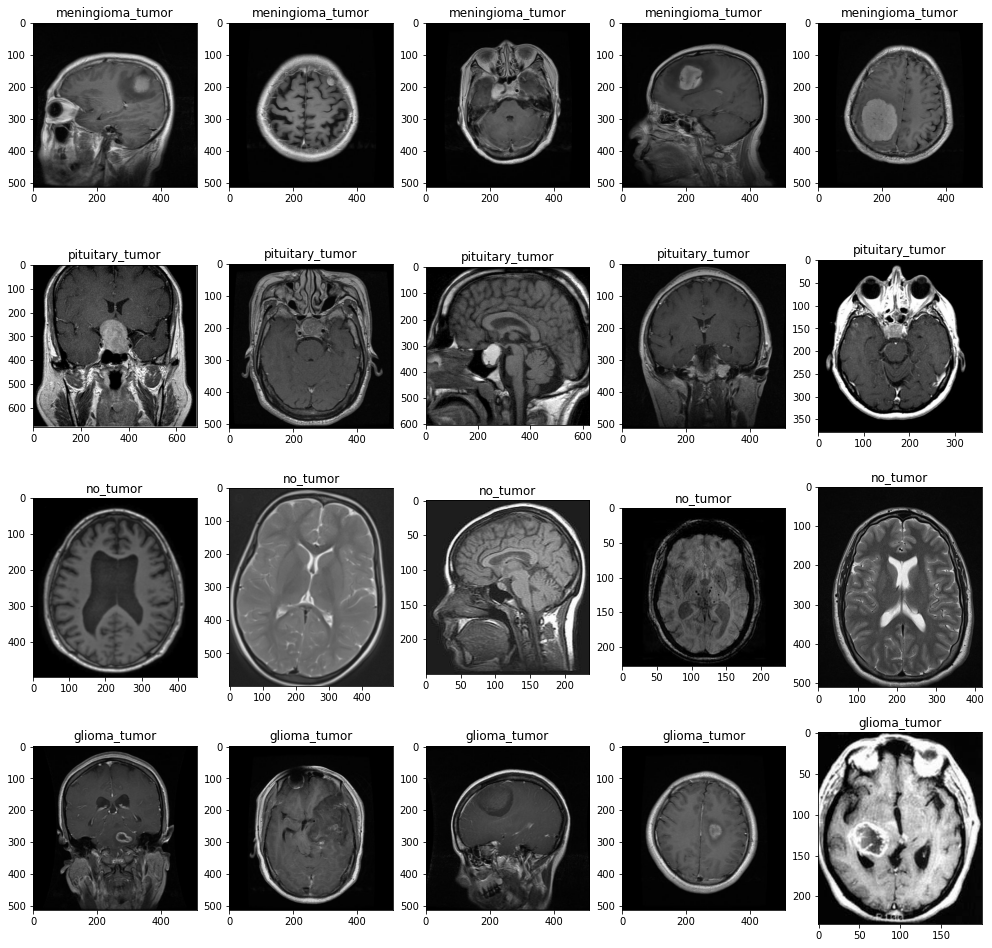

In [ ]:
train_dir = "/content/Coursera-Content/Brain-MRI/Training/"
test_dir = "/content/Coursera-Content/Brain-MRI/Testing/"
classes = os.listdir(train_dir)
files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x: train_dir+c+"/"+x,os.listdir(train_dir+c)))

index = 0
plt.figure(figsize=(17,17))

for c in classes:
  random.shuffle(files_path_dict[c])
  samples = files_path_dict[c][:5]
  
  for i in range(1,6):
    index+= 1
    plt.subplot(4,5,index)
    plt.imshow(load_img(samples[i-1]))
    plt.title(c)
plt.show()

## Create a Function to Crop Images

In [ ]:
def crop_image(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image


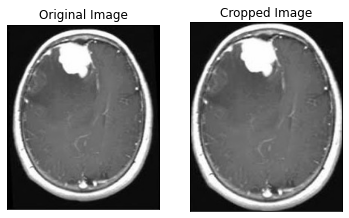

In [ ]:
sample_image = cv2.imread("/content/Coursera-Content/Brain-MRI/Training/meningioma_tumor/image(112).jpg")
crop_sample_image = crop_image(sample_image,plot=True)

## Saving The Cropped Images 

In [ ]:
# Crop the Training Images and Save it to the Directory we previously cretaed

for c in tqdm(classes):
  file_id = 0
  for f in os.listdir("/content/Coursera-Content/Brain-MRI/Training/"+c):
    f = os.path.join("/content/Coursera-Content/Brain-MRI/Training/",c,f)
    image = crop_image(cv2.imread(f))
    if image is not None:
      image = cv2.resize(image,(224,224))
      name = c+"/"+str(file_id)
      cv2.imwrite("/content/crop-Brain-MRI/"+name+".jpg",image)
      file_id+=1


100%|██████████| 4/4 [00:16<00:00,  4.13s/it]


In [ ]:
# check if the files have been cropped appropriately
print([len(os.listdir("/content/Coursera-Content/Brain-MRI/Training/"+c)) for c in classes])
print([len(os.listdir("/content/crop-Brain-MRI/"+c)) for c in classes])

[937, 901, 501, 926]
[937, 901, 501, 926]


In [ ]:
# Crop the Testing Images and Save it to the Directory we previously cretaed

for c in tqdm(classes):
  file_id = 0
  for f in os.listdir("/content/Coursera-Content/Brain-MRI/Testing/"+c):
    f = os.path.join("/content/Coursera-Content/Brain-MRI/Testing/",c,f)
    image = crop_image(cv2.imread(f))
    if image is not None:
      image = cv2.resize(image,(224,224))
      name = c+"/"+str(file_id)
      cv2.imwrite("/content/test-Data/"+name+".jpg",image)
      file_id+=1


100%|██████████| 4/4 [00:00<00:00, 33.60it/s]


In [ ]:
# check if the files have been cropped appropriately
print([len(os.listdir("/content/Coursera-Content/Brain-MRI/Testing/"+c)) for c in classes])
print([len(os.listdir("/content/test-Data/"+c)) for c in classes])

[5, 5, 5, 5]
[5, 5, 5, 5]


## Perform Data Augmentation and Prepare the Train, Validation and Test Dataset

In [ ]:
# Use Image Data Generator to perform this task.
train_gen = ImageDataGenerator(rotation_range=10,
                               height_shift_range=0.2,
                               horizontal_flip=True,
                               validation_split=0.2)

train_data = train_gen.flow_from_directory("/content/crop-Brain-MRI",
                                           target_size=(224,224),
                                           batch_size=30,
                                           class_mode='categorical',
                                           subset='training')

val_data = train_gen.flow_from_directory("/content/crop-Brain-MRI",
                                           target_size=(224,224),
                                           batch_size=30,
                                           class_mode='categorical',
                                           subset='validation')
test_gen = ImageDataGenerator()

test_data = test_gen.flow_from_directory("/content/test-Data",
                                         target_size=(224,224),
                                         class_mode = "categorical")

Found 2613 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


In [ ]:
# View the class dictionary
test_data.class_indices,train_data.class_indices

({'glioma_tumor': 0,
  'meningioma_tumor': 1,
  'no_tumor': 2,
  'pituitary_tumor': 3},
 {'glioma_tumor': 0,
  'meningioma_tumor': 1,
  'no_tumor': 2,
  'pituitary_tumor': 3})

<class 'tensorflow.python.keras.preprocessing.image.DirectoryIterator'>
30


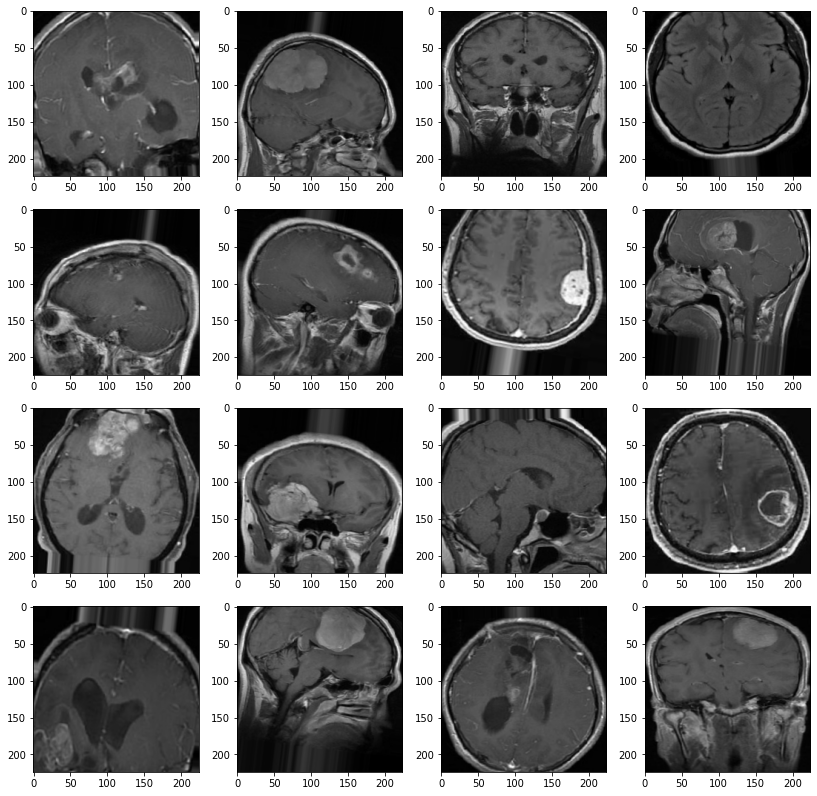

In [ ]:
# View the augmented data.
sample = next(train_data)
print(type(train_data))
print(len(sample[0]))
plt.figure(figsize=(14,14))
# plt.imshow(array_to_img(sample[0][5]))
# plt.show()

for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(array_to_img(sample[0][i]))
plt.show()

## Build and Compile the Model 

In [ ]:
# Build the Model

effnet = EfficientNetB1(weights="imagenet",include_top=False,input_shape=(224,224,3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4,activation="softmax")(model)
model = Model(inputs = effnet.input,outputs=model)
print(model.summary())

27025408/27018416 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

## Model Training and Model Evaluation

In [ ]:
# Train the model
history = model.fit(train_data,epochs=10,validation_data=val_data,verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/10
88/88 [==============================] - 55s 612ms/step - loss: 0.4990 - accuracy: 0.8243 - val_loss: 0.5595 - val_accuracy: 0.7761

Epoch 00001: val_accuracy improved from -inf to 0.77607, saving model to model.hs


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model.hs/assets
Epoch 2/10
88/88 [==============================] - 51s 580ms/step - loss: 0.2969 - accuracy: 0.9016 - val_loss: 0.4149 - val_accuracy: 0.8482

Epoch 00002: val_accuracy improved from 0.77607 to 0.84816, saving model to model.hs


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model.hs/assets
Epoch 3/10
88/88 [==============================] - 52s 586ms/step - loss: 0.1823 - accuracy: 0.9403 - val_loss: 0.3295 - val_accuracy: 0.8773

Epoch 00003: val_accuracy improved from 0.84816 to 0.87730, saving model to model.hs


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model.hs/assets
Epoch 4/10
88/88 [==============================] - 52s 586ms/step - loss: 0.1347 - accuracy: 0.9583 - val_loss: 0.2939 - val_accuracy: 0.9049

Epoch 00004: val_accuracy improved from 0.87730 to 0.90491, saving model to model.hs


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model.hs/assets
Epoch 5/10
88/88 [==============================] - 67s 765ms/step - loss: 0.1143 - accuracy: 0.9656 - val_loss: 0.2120 - val_accuracy: 0.9371

Epoch 00005: val_accuracy improved from 0.90491 to 0.93712, saving model to model.hs


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model.hs/assets
Epoch 6/10
88/88 [==============================] - 63s 712ms/step - loss: 0.0800 - accuracy: 0.9763 - val_loss: 0.1730 - val_accuracy: 0.9433

Epoch 00006: val_accuracy improved from 0.93712 to 0.94325, saving model to model.hs


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model.hs/assets
Epoch 7/10
88/88 [==============================] - 59s 668ms/step - loss: 0.0774 - accuracy: 0.9763 - val_loss: 0.1111 - val_accuracy: 0.9678

Epoch 00007: val_accuracy improved from 0.94325 to 0.96779, saving model to model.hs


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model.hs/assets
Epoch 8/10
88/88 [==============================] - 53s 597ms/step - loss: 0.0563 - accuracy: 0.9828 - val_loss: 0.1095 - val_accuracy: 0.9693

Epoch 00008: val_accuracy improved from 0.96779 to 0.96933, saving model to model.hs


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model.hs/assets
Epoch 9/10
88/88 [==============================] - 53s 598ms/step - loss: 0.0570 - accuracy: 0.9790 - val_loss: 0.0949 - val_accuracy: 0.9724

Epoch 00009: val_accuracy improved from 0.96933 to 0.97239, saving model to model.hs


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model.hs/assets
Epoch 10/10
88/88 [==============================] - 61s 685ms/step - loss: 0.0561 - accuracy: 0.9839 - val_loss: 0.0914 - val_accuracy: 0.9709

Epoch 00010: val_accuracy did not improve from 0.97239


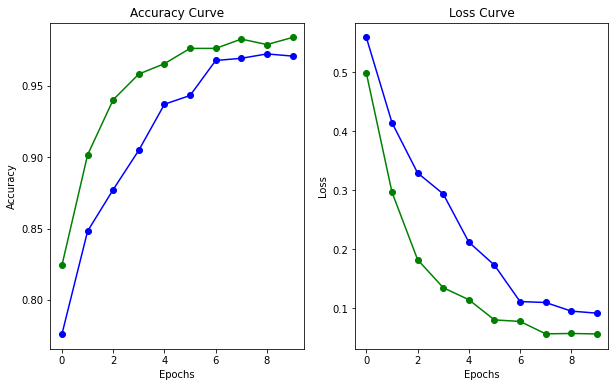

In [ ]:
# Plot the training curves
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"],"go-")
plt.plot(history.history["val_accuracy"],"bo-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")


plt.subplot(1,2,2)
plt.plot(history.history["loss"],"go-")
plt.plot(history.history["val_loss"],"bo-")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

In [ ]:
# Evaluate the model on Test Set
model.evaluate(test_data)

1/1 [==============================] - 1s 794ms/step - loss: 0.0373 - accuracy: 1.0000


[0.03733213245868683, 1.0]

## Obtaining Predictions on Test Images

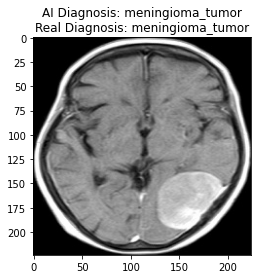

In [ ]:
# Obtain Predictions on Test Images
prediction_dict = {0:"glioma_tumor",
                   1:"meningioma_tumor",
                   2:"no_tumor",
                   3:"pituitary_tumor"}
sample_path = "/content/test-Data/meningioma_tumor/2.jpg"
real_diagnosis = sample_path.split("/")[-2]
sample_image = cv2.imread(sample_path)
plt.imshow(sample_image)
sample_image = np.expand_dims(sample_image,axis=0)
prediction = prediction_dict[np.argmax(model.predict([sample_image]))]
plt.title("AI Diagnosis: "+prediction+"\n"+"Real Diagnosis: "+real_diagnosis)
plt.show()
